This notebook shows the example of the main working procedures of the DRAid framework.

It is analogues to the `draid` command, i.e. the `__main__.py` script, although there are still some difference.

This example deliberates to explain every detail, which utilizes the notebook environment better.

## Configure

Configure the required information. In particular, the `service` must be a valid SPARQL endpoint containing provenance in a supported scheme.

In [1]:
import draid
from draid import setting  # the `setting` module is used to store configuration informations

service = 'http://127.0.0.1:3030/data'  # The SPARQL endpoint service URL

setting.SCHEME = 'SPROV'  # The scheme in thie service, either SPROV or CWLPROV.
setting.OBLIGATION_DB = 'obligation-db.json'  # The database to store the activated obligations.

## Read local database (if desired)

If you want to use local rule database, call the corresponding functions in `rule_database_helper`.

You may also want to change its database location through modifying the corresponding `setting` entries: `RULE_DB` and `DB_WRITE_TO` (see the setting module source code for detailed explanation). Or you can keep the default values, so your custom rules are read from `rule-db.json`, and the reasoning results will be discarded after finishing.

The reasoning results can be written back to the store [later](#Write-local-rule-database).

In [2]:
from draid import rule_database_helper as rdbh

# setting.RULE_DB = ['rule-db.json']
# setting.DB_WRITE_TO = True

rdbh.init_default()

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


## Check data and set up reasoner

In the example, we only uses one graph found in the service. The `draid` command by default deals with all graphs.

Check all available graphs. Then pick one (we use the first one).

In [3]:
from draid import sparql_helper as sh

if setting.SCHEME == 'SPROV':
    s_helper = sh.SProvHelper(service)
    graphs = list(s_helper.get_wfe_graphs())
    
    graph = graphs[0]

    graphs
elif setting.SCHEME == 'CWLPROV':
    s_helper = sh.CWLHelper(service)

Extract the data-flow graph from the provenance, as a `GraphWrapper` instance which is an abstract intermediate representation. It will be used in further operations.

In [4]:
from draid import graph_wrapper as gw

if setting.SCHEME == 'SPROV':
    graph_wrapper = gw.GraphWrapper.from_sprov(s_helper, subgraph=graph)
elif setting.SCHEME == 'CWLPROV':
    graph_wrapper = gw.GraphWrapper.from_cwl(s_helper)
graph_wrapper

## Visualize original data-flow graph

We can visualize the original data-flow graph, which can be compared with the [reasoning results below](#Visualise-results).

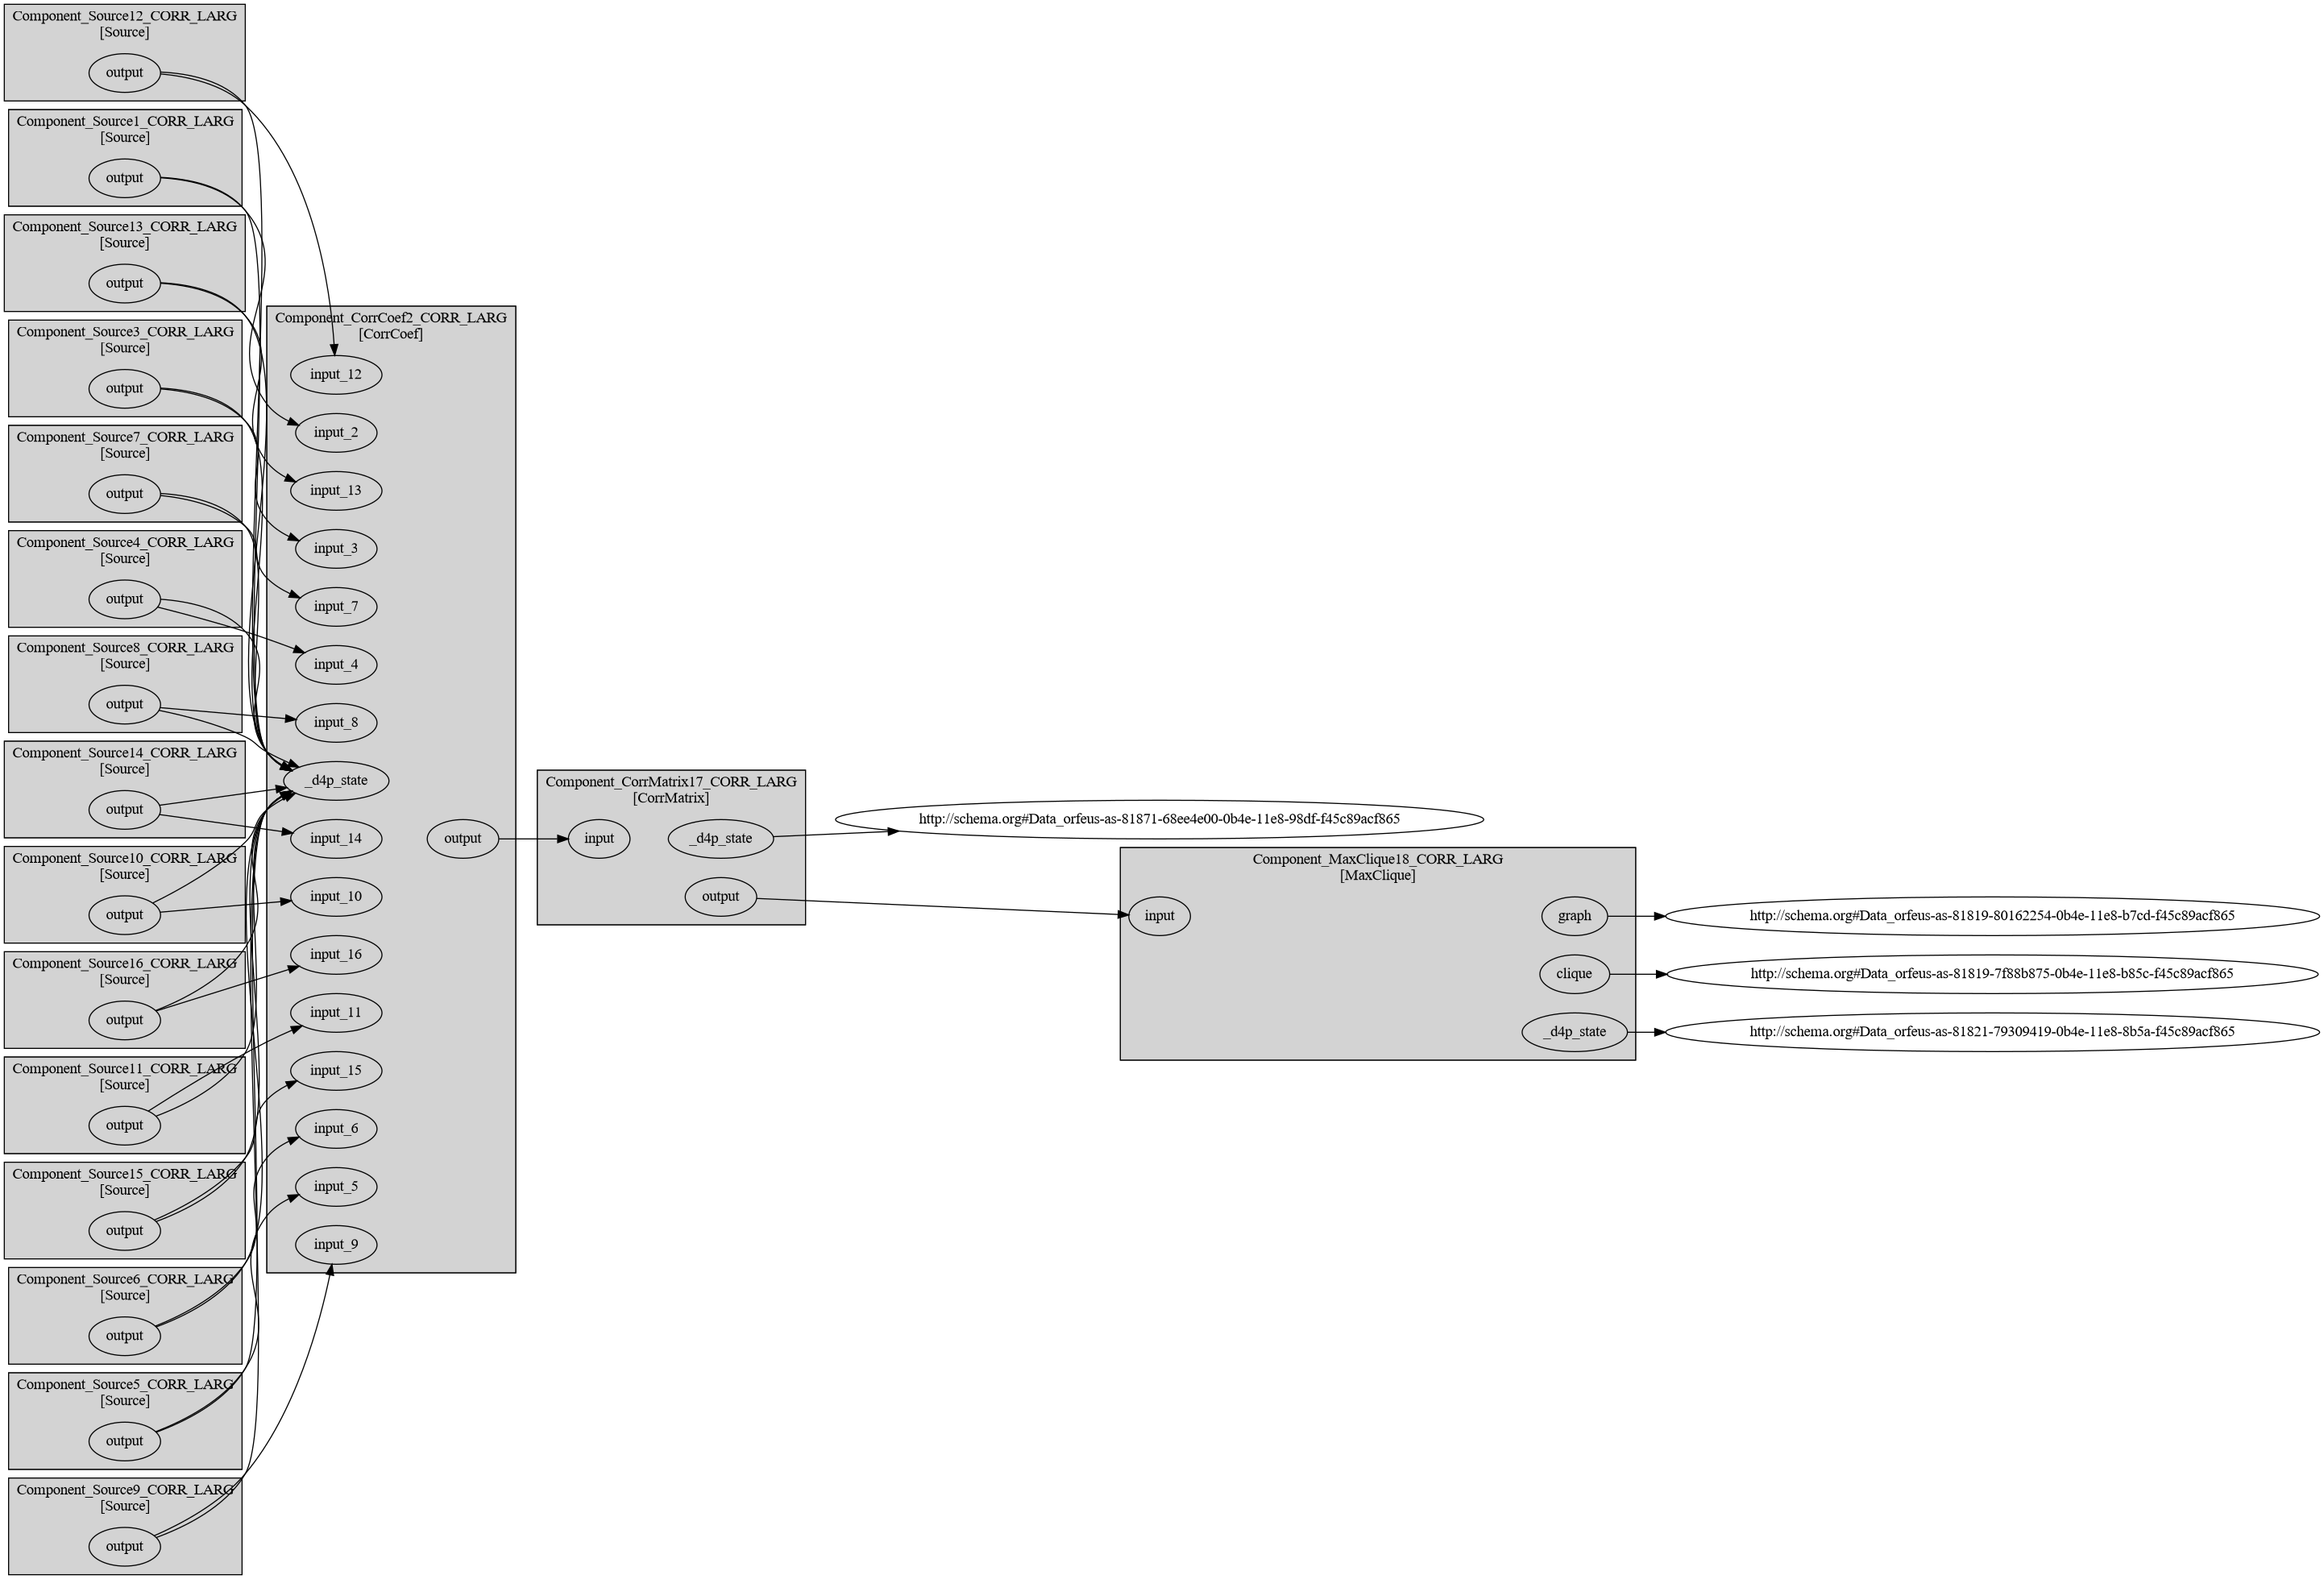

In [5]:
from IPython.display import Image
from draid import visualise as vis

filename = "graph_original.png"
gb = vis.GraphBuilder(graph_wrapper) \
        .data_flow()
G = gb.build()
vis.draw_to_file(G, filename)

Image(filename=filename) 

## Call reasonzer

Call the reasoner and obtain the results.

In [6]:
from draid import main

graph_wrapper, activated_obligations = main.propagate_single(graph_wrapper)

graph_wrapper, activated_obligations

Finished Initialization


(<draid.graph_wrapper.GraphWrapper at 0x7f11f02ef880>,
 {rdflib.term.URIRef('http://schema.org#Component_Source9_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'): [(Acknowledge [source_name(str MySource14)])],
  rdflib.term.URIRef('http://schema.org#Component_Source7_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'): [(Acknowledge [source_name(str MySource6)])],
  rdflib.term.URIRef('http://schema.org#Component_Source14_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'): [(Acknowledge [source_name(str MySource5)])],
  rdflib.term.URIRef('http://schema.org#Component_Source15_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'): [(Acknowledge [source_name(str MySource13)])],
  rdflib.term.URIRef('http://schema.org#Component_Source1_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'): [(Acknowledge [source_name(str MySource17)])],
  rdflib.term.URIRef('http://schema.org#Component_Source3_CORR_LARGE_orfeus-as-81743-

## Persist obligations

Store the obligations to the obligation database, and print all stored obligations.

In [7]:
from draid.obligation_store import ObligationStore

store = ObligationStore(setting.OBLIGATION_DB)
store.insert(activated_obligations)
store.write()

store.list()

[(rdflib.term.URIRef('http://schema.org#Component_Source9_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'),
  (Acknowledge [source_name(str MySource14)])),
 (rdflib.term.URIRef('http://schema.org#Component_Source7_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'),
  (Acknowledge [source_name(str MySource6)])),
 (rdflib.term.URIRef('http://schema.org#Component_Source14_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'),
  (Acknowledge [source_name(str MySource5)])),
 (rdflib.term.URIRef('http://schema.org#Component_Source15_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'),
  (Acknowledge [source_name(str MySource13)])),
 (rdflib.term.URIRef('http://schema.org#Component_Source1_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'),
  (Acknowledge [source_name(str MySource17)])),
 (rdflib.term.URIRef('http://schema.org#Component_Source3_CORR_LARGE_orfeus-as-81743-660827cc-0b4e-11e8-a2c5-f45c89acf865'),
  (Acknowl

## Visualise results

This is very similar to the `main.draw()` function, but modified to better suit the notebook.

We can compare the result here with the [original data-flow graph above](#Visualize-original-data-flow-graph).

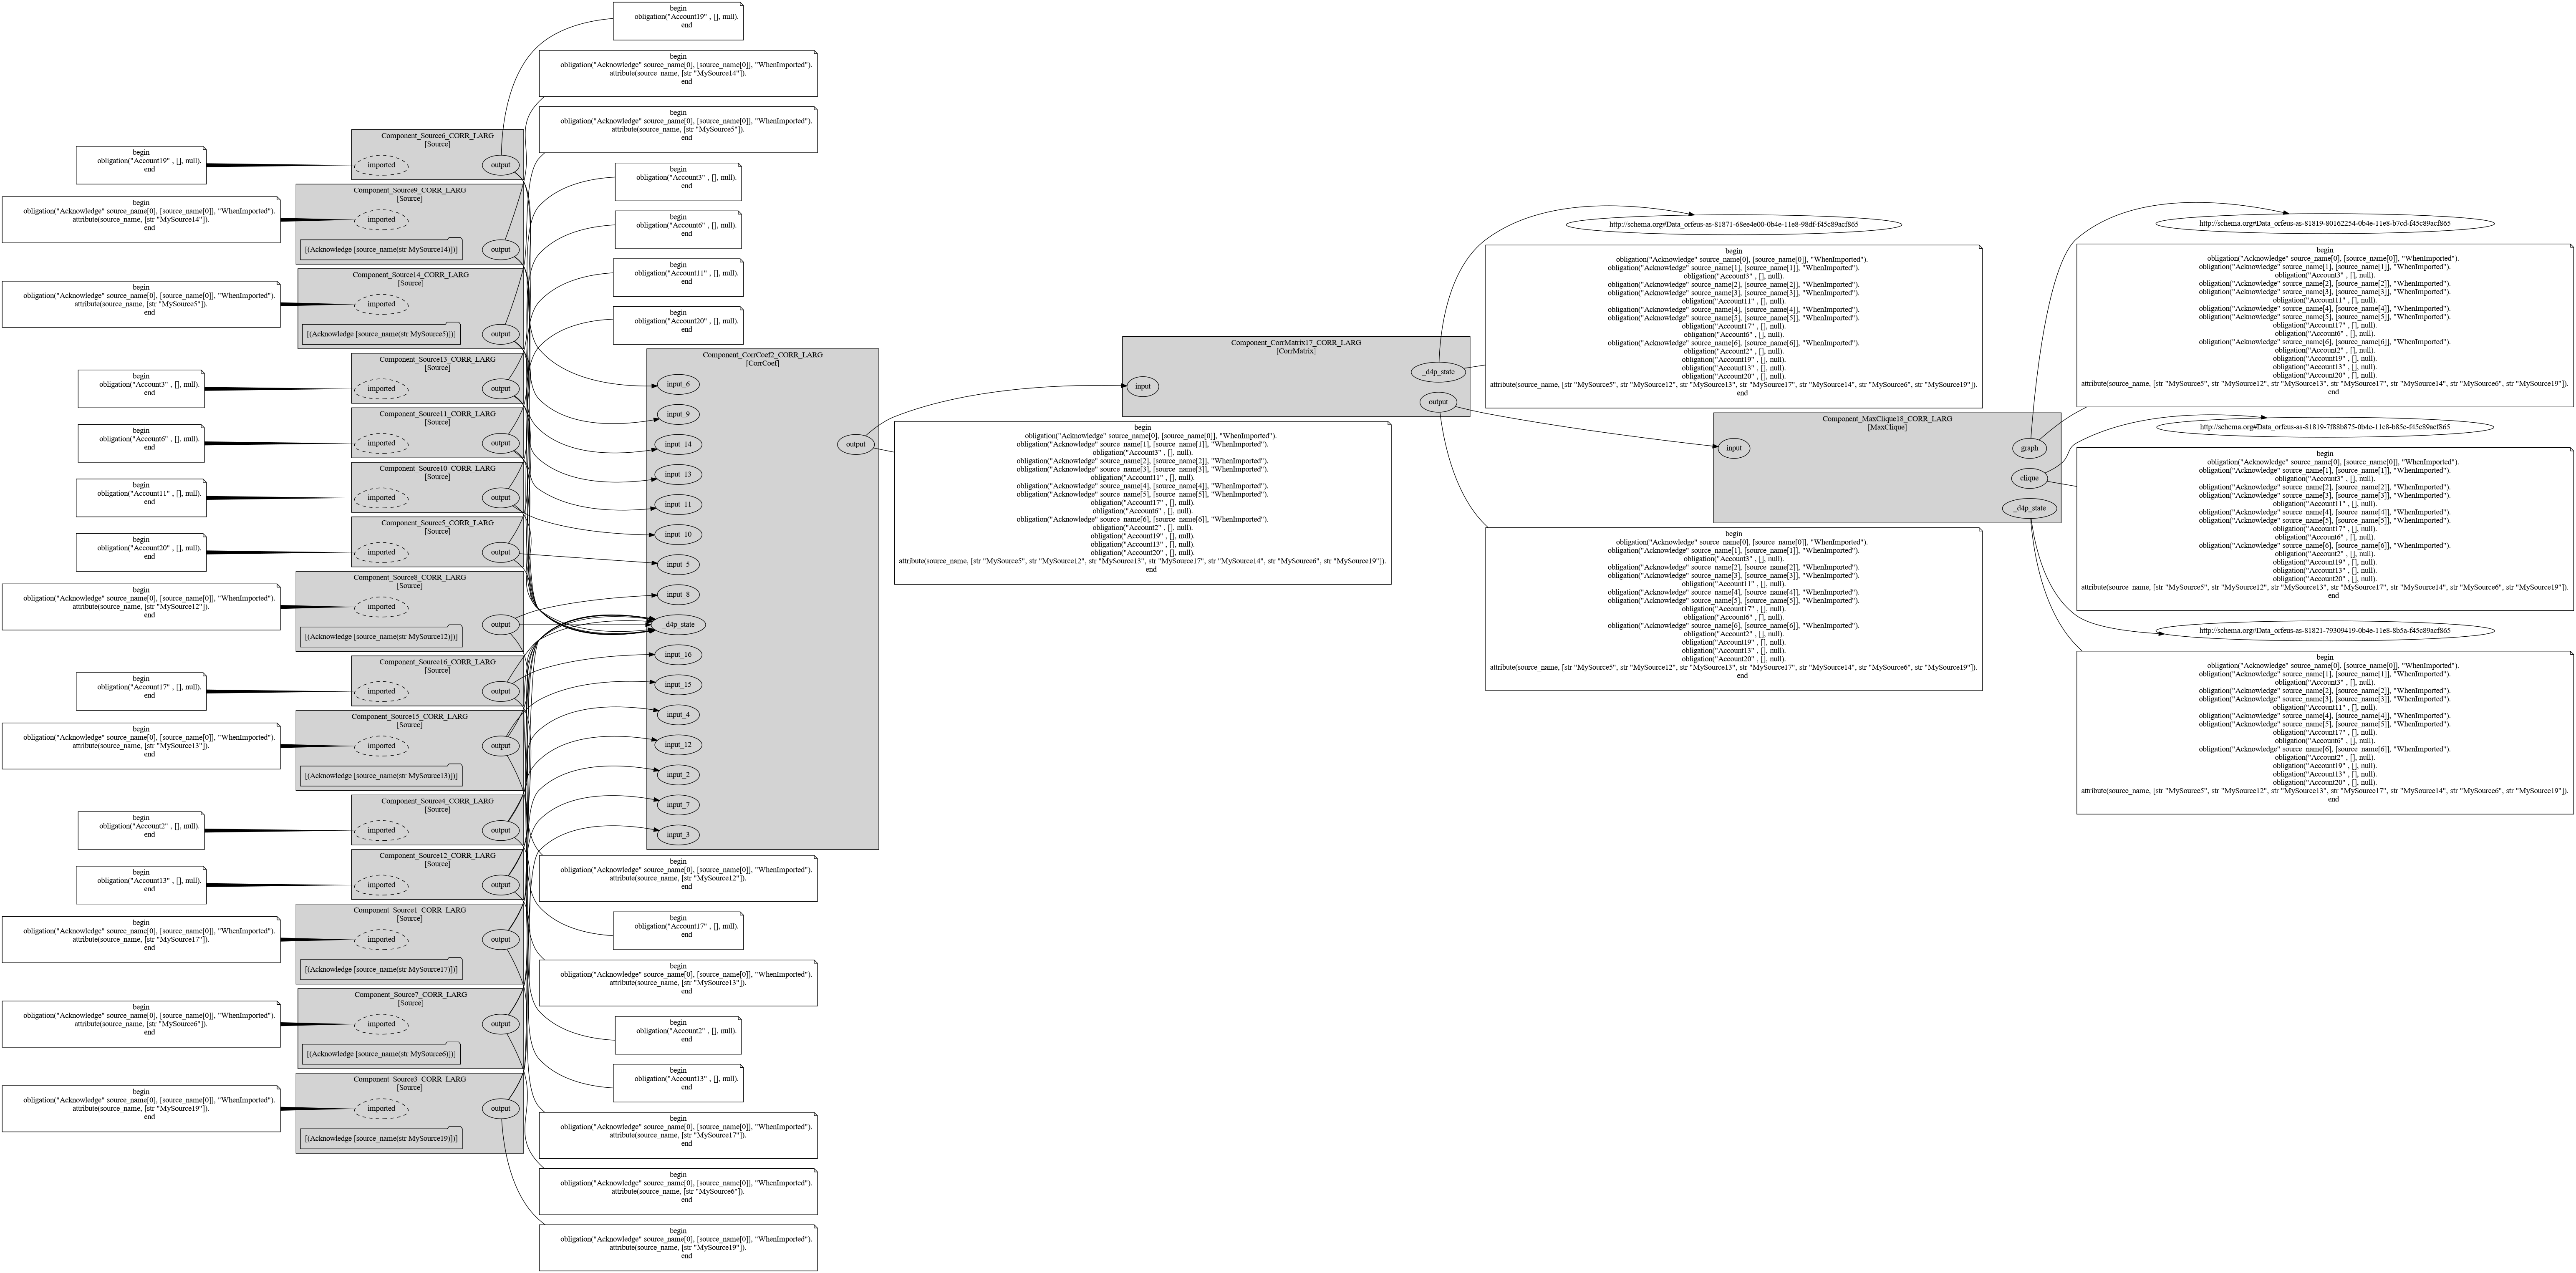

In [8]:
from IPython.display import Image
from draid import visualise as vis

filename = "graph_result.png"
gb = vis.GraphBuilder(graph_wrapper, activated_obligations) \
        .data_flow() \
        .rules() \
        .obligation() \
        .flow_rules()
G = gb.build()
vis.draw_to_file(G, filename)

    
# Display the result from the last graph
Image(filename=filename) 

## Write local rule database

Write the reasoning results to the local database (if asked), as a means to be reused for future reasonings (e.g. when another workflow uses the output data).

This depends on the configurations set [before](#Read-local-database-(if-desired)).

In [9]:
if setting.DB_WRITE_TO:
    rdbh.update_db_default(graph_wrapper)